# 04 Predictive Modeling
This notebook builds baseline and ensemble classifiers to predict return behavior and evaluates performance under class imbalance.

In [13]:
from sklearn.model_selection import train_test_split
X = df[features]  # the descriptive variable we defined earlier
y = df['return_status']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create Logistic Regression Model
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Training
model.fit(X_train, y_train)

# Predictions (using the original test set)
y_pred = model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93     22366
           1       0.03      0.81      0.06       108

    accuracy                           0.88     22474
   macro avg       0.51      0.84      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19652  2714]
 [   21    87]]


#### Explanation<br>
Total test samples: 22,474<br>
Returned orders: 108 (highly imbalanced)
- Accuracy: 0.88
- Recall: 0.81 (captures 91% of actual returns)<br>
- Precision: 0.03 (only 3% of predicted returns are correct) → Overpredicting returns<br>
- Additional Analysis Required: Apply SMOTE to handle imbalance

**Interpretation**<br>  
The logistic regression model was trained using class weights to handle imbalance.  
It achieved high recall (0.81) for the minority class (returns), but the precision was very low (0.03), indicating a high false positive rate.  
While overall accuracy was 88%, the performance on the minority class was poor, suggesting the need for oversampling techniques like SMOTE to improve prediction quality for returns.

#### - Reduce data imbalance (SMOTE)

In [15]:
# SMOTE Oversampling
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) # resample only in train data
y_resampled.value_counts()

return_status
0    89474
1    89474
Name: count, dtype: int64

In [16]:
resampled_model = LogisticRegression(max_iter=1000)
resampled_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_re = resampled_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_re))
print(confusion_matrix(y_test, y_pred_re))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     22366
           1       0.03      0.79      0.06       108

    accuracy                           0.88     22474
   macro avg       0.52      0.84      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19756  2610]
 [   23    85]]


**Interpretation**<br>  
Logistic Regression Results after Applying SMOTE:<br>  
After applying SMOTE to address class imbalance in the training data, the logistic regression model was retrained. However, the test performance remained nearly the same.<br>
In particular, the recall for the minority class (returns) slightly decreased, while precision and f1-score showed no significant improvement.<br>  

Possible reasons for this outcome:<br>  
- SMOTE only affects the training data, while the test set remains imbalanced.<br>  
- Logistic regression is a linear model and may not capture complex or non-linear relationships in the data.<br>  
- The synthetic samples generated by SMOTE might not fully reflect the true distribution of the minority class.<br>  

As a next step, applying tree-based models such as Random Forest or XGBoost is recommended to better capture non-linear patterns and improve prediction performance.

#### - Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Training (using oversampled data)
rf_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_rf = rf_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     22366
           1       0.06      0.57      0.10       108

    accuracy                           0.95     22474
   macro avg       0.53      0.76      0.54     22474
weighted avg       0.99      0.95      0.97     22474

[[21334  1032]
 [   46    62]]


#### Explanation<br>  
- Accuracy = 0.95<br>  
- Recall = 0.57 (57% of returns are predicted correctly)<br>  
- Precision = 0.06 (6% of those predicted to be returns are actually returns)<br>  
- F1-score = 0.10 (low, but better than the previous model)

**Interpretation**<br>  
Random Forest Results (with SMOTE):<br>  

The Random Forest model trained on SMOTE-resampled data achieved strong performance for the majority class (non-returns), with high precision (1.00) and recall (0.95).<br>
For the minority class (returns), recall reached 0.57 and precision improved to 0.06 (doubling from the logistic regression model).<br>
The f1-score also increased to 0.10, showing that Random Forest captured more meaningful patterns than logistic regression.<br>  

As a next step, apply XGBoost model to further improve performance on the minority class.

#### - XGBoost

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create XGBoost Model
xgb_model = xgb.XGBClassifier(random_state=42)

# Training (using oversampled data)
xgb_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_xgb = xgb_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     22366
           1       0.03      0.76      0.06       108

    accuracy                           0.88     22474
   macro avg       0.51      0.82      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19707  2659]
 [   26    82]]


#### Explanation<br>  
- Accuracy = 0.88
- Recall = 0.76 (76% of returns are detected) → fairly good performance<br>  
- Precision = 0.03 (3% of returns predicted are actually returns) → still low<br>  
- F1-score = 0.06 (impacted by low precision)

**Interpretation**<br>  

XGBoost Results (with SMOTE):<br>  

The XGBoost model trained on SMOTE-resampled data achieved a recall of 0.76 for the minority class (returns), showing strong ability to detect actual return cases.<br>
However, the precision remained low at 0.03, indicating a high number of false positives.<br>
The f1-score for the return class was 0.06, similar to previous models.<br>  

Compared to Random Forest, XGBoost showed higher recall but lower precision, resulting in a trade-off between detecting returns and avoiding incorrect predictions.<br>
This suggests that while XGBoost is effective at capturing return cases, further steps such as threshold tuning or precision-focused optimization may be needed.

#### Model Comparison & Evaluation

To evaluate the performance of the models, we focused not only on accuracy but also on recall, precision, and F1-score for the minority class (returns = 1), which is crucial in imbalanced classification tasks.

- Logistic model (after SMOTE):
  - **Accuracy**: 88%
  - **Recall (for returns)**: 79%
  - **Precision**: 3%
  - **F1-score**: 6%
- Random Forest model:
  - **Accuracy**: 95%
  - **Recall (for returns)**: 57%
  - **Precision**: 6%
  - **F1-score**: 10%
- XGBoost model:
  - **Accuracy**: 88%
  - **Recall (for returns)**: 76%
  - **Precision**: 3%
  - **F1-score**: 6%  
<br>  

- **Accuracy** is not the most reliable metric due to class imbalance.
- **F1-score** provides a better balance between precision and recall.

#### Conclusion
The **Random Forest** model shows the best overall performance with the highest F1-score and precision, making it the most suitable final model. 
Since the return class is highly imbalanced and our business interest lies in identifying potential returns, I focused on recall and F1-score of the positive class (returned items) as primary evaluation metrics.
However, if the goal is to maximize detection of returns (i.e., prioritize recall), Logistic Regression or XGBoost could also be reasonable choices.

#### - Visualize performance comparisons by model

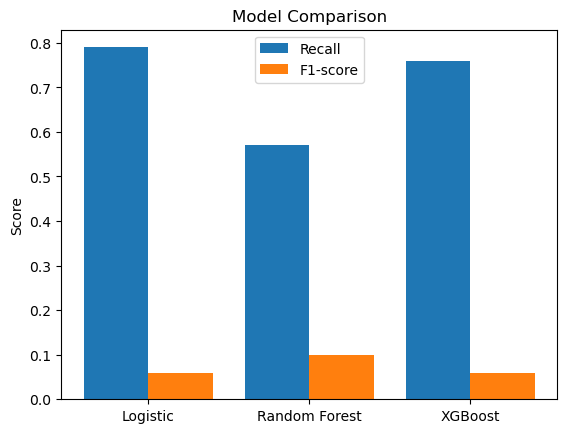

In [19]:
import matplotlib.pyplot as plt

models = ['Logistic', 'Random Forest', 'XGBoost']
recalls = [0.79, 0.57, 0.76]
f1_scores = [0.06, 0.10, 0.06]

x = range(len(models))
plt.bar(x, recalls, width=0.4, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()

#### Explanation
Based on evaluation metrics, I selected the Random Forest model for further interpretation.
The SHAP (SHapley Additive exPlanations) method is applied to this model to understand the contribution of each feature to return prediction.

#### Conclusion
- Lower review scores are moderately associated with higher return likelihood.
- Product category significantly impacts return rate, suggesting a potential for targeted quality control.
- Random Forest model performed best in balancing recall and precision for return prediction.
- SHAP analysis (see app.py) further explains feature contributions and supports interpretability.

#### - Save the Trained Model and Training Data

In [20]:
import joblib

joblib.dump(rf_model, "model.pkl")

['model.pkl']

In [21]:
# Make csv file for X_train data
X_train.to_csv("X_train.csv", index=False)

# Make csv file for y_train data
y_train.to_csv("y_train.csv", index=False)

# Make csv file for df
df.to_csv("olist_cleaned.csv", index=False)

In [22]:
# Check the return status count
y_train.value_counts(normalize=True)

return_status
0    0.995317
1    0.004683
Name: proportion, dtype: float64